# SMAI Assignment - 3

## Question - `3` : Knowing MLPs

| | |
|- | -|
| Course | Statistical Methods in AI |
| Release Date | `09.03.2023` |
| Due Date | `24.03.2023` |

## Please read the following before moving on

Welcome to the world of Multilayer Perceptrons (MLP)! You already know that MLPs are feedforward neural networks consisting of multiple layers of nodes or neurons. These networks are well-suited for a wide range of classification and regression tasks, thanks to their ability to learn complex, non-linear relationships between inputs and outputs.

In this assignment, we will be working with the MNIST dataset to explore the importance of different MLP components. The MNIST dataset consists of 70,000 handwritten digit images, each of which is 28x28 pixels in size. Our goal is to use an MLP to classify these images into one of 10 categories (0-9).

To improve the performance of our MLP, we will experiment with various techniques such as Dropout, Batch Normalization, Loss Functions, Stochastic batch and mini-batch gradient descent, and more. Please note, you must use mini-batch unless explicity specified.

In addition, we will experiment with different optimization algorithms such as stochastic gradient descent, Adam, and RMSprop to find the optimal weights and biases for our MLP. We will use stochastic batch and mini-batch gradient descent, which involve updating the weights and biases of the network based on a small batch of randomly sampled training examples, to speed up the training process and reduce memory usage.

By the end of this assignment, you will have gained a deeper understanding of the various components that make up an MLP and their importance in achieving high performance in classification tasks. You will have gained hands-on experience in experimenting with these components and learned how to fine-tune an MLP to achieve the best possible performance on the MNIST dataset. So, let's get started!

🫵Pro-tip: Do not re-write any results so as to re-use them in later experiments for tabulation and plotting.

💭Trivia: Did you know code written using ChatGPT is easy to catch?

### Step zero: Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib
import seaborn as sns
%matplotlib inline

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn

In [2]:
torch.cuda.is_available()

True

### Step one: Using a PyTorch Dataset
Load MNIST dataset from `torchvision.datasets`

In [3]:
transform = transforms.Compose([
                    transforms.ToTensor(), 
            ])

trainset = datasets.MNIST(root='./', train=True, download=True, transform=transform) #TODO use datasets.MNIST
testset = datasets.MNIST(root='./', train=False, download=True, transform=transform)#TODO

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
trainloader_minibatch = torch.utils.data.DataLoader(trainset, batch_size=64
                                                    , shuffle=True, num_workers=2)
trainloader_stochastic = torch.utils.data.DataLoader(trainset, batch_size=1
                                                     , shuffle=True, num_workers=2)
testloader_minibatch = torch.utils.data.DataLoader(testset, batch_size = 64, num_workers = 2)#TODO
testloader_stochastic = torch.utils.data.DataLoader(testset, batch_size = 1, num_workers = 2)

In [5]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from tqdm import tqdm # smart progress meter
pbar = tqdm(total=len(trainloader_minibatch))
for idx, (data,label) in enumerate(trainloader_minibatch):
    print(idx,data.size(),label.size())
    pbar.update(1)
    break
pbar.refresh()

  0%|          | 1/938 [00:00<02:31,  6.20it/s]

0 torch.Size([64, 1, 28, 28]) torch.Size([64])


True

### Step two: Define a MLP Model and without any bells and whitsles...
... along with a CrossEntropy loss criterion 

Do not use Dropout, BN or any other thing. Use ReLU for hidden layers.

⚠️ Do not use SoftMax in the output as nn.CrossEntropyLoss combines SoftMax and NLLLoss.

In [7]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP,self).__init__()
        # code here
        self.fc1 = nn.Linear(28*28,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,10)
        

    def forward(self,x):
        # code here
        output = torch.relu(self.fc1(x))
        output = torch.relu(self.fc2(output))
        output = self.fc3(output)
        return output

### Step three: Define the following optimizers using nn.optim
1. SGD
2. SGD with momentum
3. SGD with L2 regularization
4. RMSprop
5. Adam

In [8]:
# model = SimpleMLP()
# model.to('cuda')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleMLP().to(device)

In [9]:
# code here
import torch.optim as optim
learning_rate = 0.003
momentum = 0.9
weight_decay = 0.001
alpha = 0.9
eps = 0
beta1 = 0.1
beta2 = 0.1

optimizer_1 = optim.SGD(model.parameters(), lr=learning_rate)
optimizer_2 = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
optimizer_3 = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_4 = optim.RMSprop(model.parameters(), lr=learning_rate, alpha=alpha, eps=eps)
# optimizer_5 = optim.Adam(model.parameters(), lr=learning_rate, betas=(beta1, beta2), eps=eps)
optimizer_5 = optim.Adam(model.parameters(), lr=learning_rate)


### Step four: Run the SimpleMLP using different optimizers and plot train and test loss for each optimizer.
Explain the results.

Report final accuracy, F1 score and other relavant metrics in a tabular form on test and train datasets.

In [10]:
# code, plots and explainiation here
import time

train_predictions = []
train_targets = []
criterion = nn.CrossEntropyLoss()
# Loss and optimizer
def runner(trainloader,testloader,n_epoch,optimizer,mo,scheduler=None):
  begin = time.time()
 
  # optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  

  # Train the model
  num_epochs = n_epoch
  n_total_steps = len(trainloader)
  test_loss = []
  train_loss_l = []
  for epoch in range(num_epochs):
      train_loss = 0
      mo.train()
      for i, (images, labels) in enumerate(trainloader):  
          # origin shape: [100, 1, 28, 28]
          # resized: [100, 784]
          images = images.reshape(images.shape[0], -1).to(device)
          labels = labels.to(device)
          
          # Forward pass and loss calculation
          outputs = mo(images)
          loss = criterion(outputs, labels)
          
          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      
          train_loss += loss.item()
      if scheduler != None :
        scheduler.step()
      _,ol= check_accuracy(testloader,mo)
      test_loss.append(ol)
      Loss = train_loss / len(trainloader)
      train_loss_l.append(Loss)
      print("Epoch :",epoch,"Loss",Loss)
  end = time.time()
  print("Time Taken :",end-begin)
  return mo,test_loss,train_loss_l


In [11]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0], -1)

            scores = model(x)
            xyz, predictions = scores.max(1)
            y_i = 0
            for k in predictions:
              if k == y[y_i]:
                num_correct +=1
              y_i = y_i + 1
            num_samples += predictions.size(0)
            test_loss += criterion(scores, y).cpu().item()
    return num_correct/num_samples,test_loss/len(loader)




In [12]:
import matplotlib.pyplot as plt
def plot_losses(train_loss,test_loss,epoch_list):  
  plt.plot(epoch_list, train_loss, label='Training loss')
  plt.plot(epoch_list,test_loss, label='Test loss')
  plt.title('Training loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss ')
  plt.legend()
  plt.show()

Epoch : 0 Loss 2.270650764518201
Epoch : 1 Loss 2.05476270911536
Epoch : 2 Loss 1.4010929484992647
Epoch : 3 Loss 0.834125048697376
Epoch : 4 Loss 0.6083210016300937
Epoch : 5 Loss 0.5070059802581761
Epoch : 6 Loss 0.45240308190269
Epoch : 7 Loss 0.41867867909641915
Epoch : 8 Loss 0.3952728795058438
Epoch : 9 Loss 0.3779461490415307
Time Taken : 117.7234046459198
(0.8976, 0.3560156210260406)


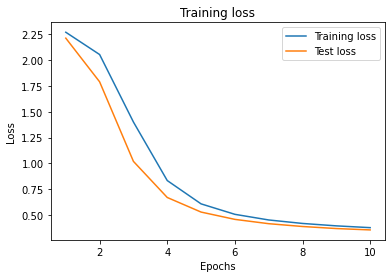

Epoch : 0 Loss 0.9524768050005441
Epoch : 1 Loss 0.3286725600470485
Epoch : 2 Loss 0.26603943571003513
Epoch : 3 Loss 0.2218914736491213
Epoch : 4 Loss 0.18917505657558503
Epoch : 5 Loss 0.1646884967431998
Epoch : 6 Loss 0.14496700636454737
Epoch : 7 Loss 0.12942086214592843
Epoch : 8 Loss 0.11555416657944828
Epoch : 9 Loss 0.10510784056264041
Time Taken : 109.12140965461731
(0.9681, 0.11059620802492426)


Epoch : 0 Loss 2.2485563597445295
Epoch : 1 Loss 1.9353458716162741
Epoch : 2 Loss 1.2598632957254137
Epoch : 3 Loss 0.7834755820569708
Epoch : 4 Loss 0.5915530884443824
Epoch : 5 Loss 0.502987414598465
Epoch : 6 Loss 0.45242260685607566
Epoch : 7 Loss 0.41976253540594693
Epoch : 8 Loss 0.39672146894847915
Epoch : 9 Loss 0.3790403837079941
Time Taken : 117.01914644241333
(0.8975, 0.35768217114126605)


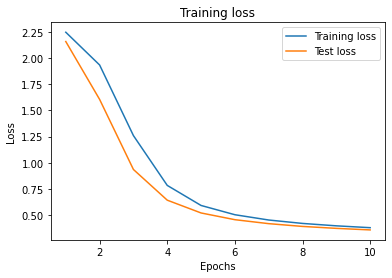

Epoch : 0 Loss 0.2451732229711468
Epoch : 1 Loss 0.10989185860643644
Epoch : 2 Loss 0.08564005212667562
Epoch : 3 Loss 0.06923695223973513
Epoch : 4 Loss 0.06338151889110505
Epoch : 5 Loss 0.05599521909648686
Epoch : 6 Loss 0.05280732001182008
Epoch : 7 Loss 0.049792135354478746
Epoch : 8 Loss 0.043433455693025355
Epoch : 9 Loss 0.041641662359055434
Time Taken : 119.8877604007721
(0.9751, 0.1766173398053303)


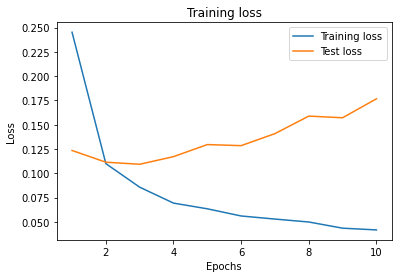

Epoch : 0 Loss 0.25957545919069797
Epoch : 1 Loss 0.10522751370742758
Epoch : 2 Loss 0.07820929145377908
Epoch : 3 Loss 0.06095273557393603
Epoch : 4 Loss 0.04962354062186149
Epoch : 5 Loss 0.04440871709097015
Epoch : 6 Loss 0.03692360807421256
Epoch : 7 Loss 0.03625644233163649
Epoch : 8 Loss 0.03143997223021575
Epoch : 9 Loss 0.02826603242338528
Time Taken : 128.70326495170593
(0.9767, 0.09782099601227619)


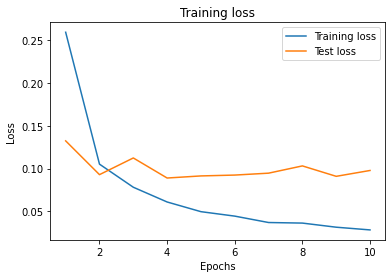

In [13]:

epoch_list =[i for i in range(1,11)]

model_1 = SimpleMLP().to(device)
optimizer_1 = optim.SGD(model_1.parameters(), lr=learning_rate)
mod_n,test_list_n,train_list_n = runner(trainloader_minibatch,testloader_minibatch,10,optimizer_1,model_1,None)
print(check_accuracy(testloader_minibatch,mod_n))
plot_losses(train_list_n,test_list_n,epoch_list)

model_2 = SimpleMLP().to(device)
optimizer_2 = optim.SGD(model_2.parameters(), lr=learning_rate, momentum=0.9)
mod_n,test_list_n,train_list_n = runner(trainloader_minibatch,testloader_minibatch,10,optimizer_2,model_2,None)
print(check_accuracy(testloader_minibatch,mod_n))
plot_losses(train_list_n,test_list_n,epoch_list)

model_3 = SimpleMLP().to(device)
optimizer_3 = optim.SGD(model_3.parameters(), lr=learning_rate, weight_decay=weight_decay)
mod_n,test_list_n,train_list_n = runner(trainloader_minibatch,testloader_minibatch,10,optimizer_3,model_3,None)
print(check_accuracy(testloader_minibatch,mod_n))
plot_losses(train_list_n,test_list_n,epoch_list)

model_4 = SimpleMLP().to(device)
optimizer_4 = optim.RMSprop(model_4.parameters(), lr=learning_rate, alpha=alpha)
mod_n,test_list_n,train_list_n = runner(trainloader_minibatch,testloader_minibatch,10,optimizer_4,model_4,None)
print(check_accuracy(testloader_minibatch,mod_n))
plot_losses(train_list_n,test_list_n,epoch_list)

model_5 = SimpleMLP().to(device)
optimizer_5 = optim.Adam(model_5.parameters(), lr=learning_rate)
mod_n,test_list_n,train_list_n = runner(trainloader_minibatch,testloader_minibatch,10,optimizer_5,model_5,None)
print(check_accuracy(testloader_minibatch,mod_n))
plot_losses(train_list_n,test_list_n,epoch_list)

In [14]:
# print(mod_n)

Each optimizer has its own set of hyperparameters that can affect the learning rate and momentum, which can impact the model's performance.
If an optimizer is performing well, you can expect to see a decrease in both the train and test loss over time, indicating that the model is learning the underlying patterns in the data. If an optimizer is not performing well, you may see that the model is overfitting to the training data, as indicated by a decrease in the train loss but an increase in the test loss.

### Step five: Using SimpleMLP and Adam optimizer, train models using 2 different lr_schedulers.
Select 2 of **MultiplicativeLR**, **MultiStepLR**, **LinearLR** and **ExponentialLR**

Compare the results among different LR schedulers and the original model which didn't employ any LR scheduler. Compile results in a tabular form. Plot losses for each. Explain results.

In [15]:
# code and analysis here
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import LinearLR
model_5 = SimpleMLP().to(device)
optimizer_5 = optim.Adam(model_5.parameters(), lr=0.01)
model_6 = SimpleMLP().to(device)
optimizer_6 = optim.Adam(model_6.parameters(), lr=0.01)
scheduler1 = ExponentialLR(optimizer_5, 
                          gamma = 0.95) # Multiplicative factor of learning rate decay.

scheduler2 = LinearLR(optimizer_6, 
                     start_factor = 0.5, # The number we multiply learning rate in the first epoch
                     total_iters = 8) # The number of iterations that multiplicative factor reaches to 1


mod,test_list,train_list = runner(trainloader_minibatch,testloader_minibatch,10,optimizer_5,model_5,scheduler1)
print(check_accuracy(testloader_minibatch,mod))
plot_losses(train_list,test_list,epoch_list)


mod,test_list,train_list = runner(trainloader_minibatch,testloader_minibatch,10,optimizer_6,model_6,scheduler2)
print(check_accuracy(testloader_minibatch,mod))
plot_losses(train_list,test_list,epoch_list)



Epoch : 0 Loss 0.24674625635774597
Epoch : 1 Loss 0.13896246438822163
Epoch : 2 Loss 0.1147910738497901
Epoch : 3 Loss 0.09728370435974762
Epoch : 4 Loss 0.08286327402573328
Epoch : 5 Loss 0.07739470290530946
Epoch : 6 Loss 0.0639757677730084
Epoch : 7 Loss 0.055194857346318064
Epoch : 8 Loss 0.052322641808074
Epoch : 9 Loss 0.042696240077790645
Time Taken : 131.55363202095032
(0.9748, 0.13064860777558207)


Epoch : 0 Loss 0.23282826739722795
Epoch : 1 Loss 0.11587744080441705
Epoch : 2 Loss 0.09729650243645165
Epoch : 3 Loss 0.09342251519170175
Epoch : 4 Loss 0.09387827750957156
Epoch : 5 Loss 0.09034231197134134
Epoch : 6 Loss 0.09258021197502943
Epoch : 7 Loss 0.09216768463961467
Epoch : 8 Loss 0.08981391006621715
Epoch : 9 Loss 0.08213770577493784
Time Taken : 139.89545345306396
(0.9624, 0.17099559849412121)


The results suggest that LR schedulers can be effective for improving the performance of deep learning models, and different LR schedulers may be more or less effective depending on the problem at hand.

### Step six: Define 3 models with following changes:
1. Add BatchNorm
2. Add Dropout
3. Add BatchNorm and Dropout

In [16]:
class SimpleMLPBatch_norm(nn.Module):
    def __init__(self):
        super(SimpleMLPBatch_norm, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        return x


In [17]:
class ModelWithBatchNormAndDropout(nn.Module):
    def __init__(self):
        super(ModelWithBatchNormAndDropout, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x



In [18]:
class ModelWithDropout(nn.Module):
    def __init__(self):
        super(ModelWithDropout, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout1(x)
        x = nn.functional.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x



### Step seven: Train the above models and compare with SimpleMLP.

Use your choice of optimizer, use no lr_scheduler so as to re-use the previous results.

Perform analysis. You've got the drill by now.

Epoch : 0 Loss 0.19801301893982678
Epoch : 1 Loss 0.09887402221612109
Epoch : 2 Loss 0.07573677200589703
Epoch : 3 Loss 0.06253581822140893
Epoch : 4 Loss 0.052512341205823494
Epoch : 5 Loss 0.046846764173290666
Epoch : 6 Loss 0.041802679519427184
Epoch : 7 Loss 0.03871446894391798
Epoch : 8 Loss 0.03318739339335028
Epoch : 9 Loss 0.029944985294091536
Time Taken : 147.63803625106812
(0.9808, 0.06810688042141166)


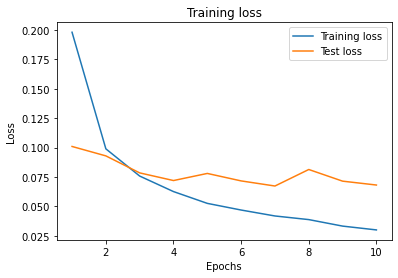

Epoch : 0 Loss 0.31163661406317883
Epoch : 1 Loss 0.20330275572153297
Epoch : 2 Loss 0.1734131862188993
Epoch : 3 Loss 0.15605068574649597
Epoch : 4 Loss 0.14368085224610339
Epoch : 5 Loss 0.13910769894897843
Epoch : 6 Loss 0.12775723681922183
Epoch : 7 Loss 0.12432918205325093
Epoch : 8 Loss 0.12187538475894344
Epoch : 9 Loss 0.1138524891156306
Time Taken : 128.06139993667603
(0.9802, 0.06513098869968156)


Epoch : 0 Loss 0.3342376631468153
Epoch : 1 Loss 0.16069275733512411
Epoch : 2 Loss 0.12942182963122245
Epoch : 3 Loss 0.11354996273636635
Epoch : 4 Loss 0.10096534804901731
Epoch : 5 Loss 0.09311450403362417
Epoch : 6 Loss 0.08757373296543022
Epoch : 7 Loss 0.08187149136465217
Epoch : 8 Loss 0.07629478378876695
Epoch : 9 Loss 0.07213504358044844
Time Taken : 119.66967129707336
(0.9803, 0.06831798952462007)


In [19]:
# code here
model_7 = SimpleMLPBatch_norm().to(device)
optimizer_7 = optim.Adam(model_7.parameters(), lr=0.01)
mod_n,test_list_n,train_list_n = runner(trainloader_minibatch,testloader_minibatch,10,optimizer_7,model_7,None)
epoch_list =[i for i in range(1,11)]
print(check_accuracy(testloader_minibatch,mod_n))
plot_losses(train_list_n,test_list_n,epoch_list)

model_8 = ModelWithBatchNormAndDropout().to(device)
optimizer_8 = optim.Adam(model_8.parameters(),lr=0.01)
mod_n,test_list_n,train_list_n = runner(trainloader_minibatch,testloader_minibatch,10,optimizer_8,model_8,None)
epoch_list =[i for i in range(1,11)]
print(check_accuracy(testloader_minibatch,mod_n))
plot_losses(train_list_n,test_list_n,epoch_list)

model_9 = ModelWithDropout().to(device)
optimizer_9 = optim.Adam(model_9.parameters())
mod_n,test_list_n,train_list_n = runner(trainloader_minibatch,testloader_minibatch,10,optimizer_9,model_9,None)
epoch_list =[i for i in range(1,11)]
print(check_accuracy(testloader_minibatch,mod_n))
plot_losses(train_list_n,test_list_n,epoch_list)

### Step eight: Mini-batch vs Stocastic
Now that you might have a clear winner in your mind regarding which model and settings perform the best, train it on mini-batch and stocastic and compare time taken, loss curve, accuracy etc.

Perform an analysis like never before!

Epoch : 0 Loss 0.3739960133703301
Epoch : 1 Loss 0.14552617632293735
Epoch : 2 Loss 0.1058937566375104
Epoch : 3 Loss 0.08756788206127694
Epoch : 4 Loss 0.07632049069149918
Epoch : 5 Loss 0.06920724053905296
Epoch : 6 Loss 0.06472306072097717
Epoch : 7 Loss 0.06044652242685887
Epoch : 8 Loss 0.05791098183869319
Epoch : 9 Loss 0.056023735806039116
Time Taken : 2004.259346961975
(0.9756, 0.0762703612137422)


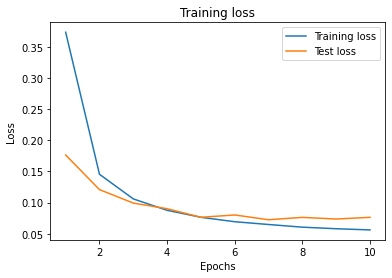

In [20]:
# code here
epoch_list =[i for i in range(1,11)]
model_10 = SimpleMLP().to(device)
optimizer_10 = optim.SGD(model_10.parameters(), lr=learning_rate, weight_decay=weight_decay)
mod_n,test_list_n,train_list_n = runner(trainloader_stochastic,testloader_stochastic,10,optimizer_10,model_10,None)
print(check_accuracy(testloader_stochastic,mod_n))
plot_losses(train_list_n,test_list_n,epoch_list)




Epoch : 0 Loss 2.247336620206772
Epoch : 1 Loss 1.957955858219407
Epoch : 2 Loss 1.2646434140612068
Epoch : 3 Loss 0.7772597666424729
Epoch : 4 Loss 0.5948149985405428
Epoch : 5 Loss 0.5076867196160847
Epoch : 6 Loss 0.4557602816044903
Epoch : 7 Loss 0.42069543038667645
Epoch : 8 Loss 0.3954916549072083
Epoch : 9 Loss 0.3764757350055394
Time Taken : 110.99115419387817
(0.8996, 0.3509237852872937)


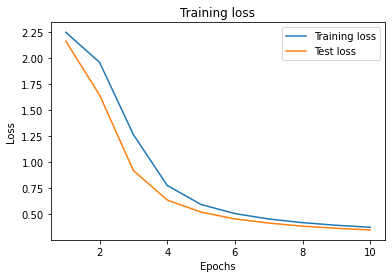

In [21]:
model_11 = SimpleMLP().to(device)
optimizer_11 = optim.SGD(model_11.parameters(), lr=learning_rate, weight_decay=weight_decay)
mod_n,test_list_n,train_list_n = runner(trainloader_minibatch,testloader_minibatch,10,optimizer_11,model_11,None)
print(check_accuracy(testloader_minibatch,mod_n))
plot_losses(train_list_n,test_list_n,epoch_list)

### And most importantly!!! What did we learn?
Discuss any and all learnings here. The discussions must be all-encompassing so that we know what did you learn. 

Please do not copy from your friend or copy-paste from the internet. We can see repetitions during evaluations.

Activation Functions:The activation functions used in MLP can have a significant impact on its learning.

Backpropagation Algorithm:It works by propagating the error backwards through the network and adjusting the weights of the connections to minimize the error. The learning rate, which determines the magnitude of weight updates, can significantly impact the convergence and performance of MLP. A small learning rate can lead to slow convergence, while a large learning rate can cause overshooting and unstable training.

Dropout Layer is used to regularize the model.(prevent overfitting).

BatchNorm Layer is used to normalize the data if we need data in a range.(normalize).BatchNorm layer transforms the inputs to have zero mean and unit variance across the batch dimension.


